In [124]:
from optuna.integration.lightgbm import lgb
import pandas as pd
import numpy as np
import optuna
import shap
import pickle
import os
from tqdm import tqdm
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [125]:
start_date = '2023-7-1'
end_date = '2023-7-31'

In [126]:
df = pd.read_csv('train_merged.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
ignore_features_binary = ['end_code', 'start_code', 'KP', 'is_congestion', 'holiday', 'speed_change_hour_move_ave_7d']
ignore_features_reg = ['end_code', 'start_code', 'KP', 'is_congestion', 'holiday', 'search_specified_same_day_hour_mean', 'search_unspecified_same_day_mean', 'OCC_hour_move_ave_7d']
categorical_features = ['day_of_week', 'section', 'n_of_holidays']

# sample_weightに入れる重みを計算
coef_binary_0 = 1
coef_binary_1 = 1

weight_binary = compute_sample_weight(class_weight='balanced', y=df['is_congestion_tomorrow'])
weight_df = pd.DataFrame()
weight_df['is_congestion_tomorrow'] = df['is_congestion_tomorrow']
weight_df['weight_binary'] = weight_binary
weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight_binary'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight_binary'] * coef_binary_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight_binary'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight_binary'] * coef_binary_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
df['weight_binary'] = weight_df['weight_binary']

coef_reg_0 = 1
coef_reg_1 = 100

weight_reg = compute_sample_weight(class_weight='balanced', y=df['speed_tomorrow'])
weight_df = pd.DataFrame()
weight_df['speed_tomorrow'] = df['speed_tomorrow']
weight_df['weight_reg'] = weight_reg
weight_df.loc[weight_df['speed_tomorrow'] > 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] > 40]['weight_reg'] * coef_reg_0).set_axis(weight_df.loc[weight_df['speed_tomorrow'] > 40].index)
weight_df.loc[weight_df['speed_tomorrow'] <= 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] <= 40]['weight_reg'] * coef_reg_1).set_axis(weight_df.loc[weight_df['speed_tomorrow'] <= 40].index)
df['weight_reg'] = weight_df['weight_reg']


#df_train = df.copy()
df_train = df[df['datetime'] < start_date+' 00:00:00']
df_train = df_train[df_train['tomorrow_holiday'] == 1]
df_test = df[(df['datetime'] >= start_date+' 00:00:00') & (df['datetime'] <= end_date+' 23:00:00')]
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

predictions = []

folds = tss(n_splits=5)

test_x_binary = df_test.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'tomorrow_holiday', 'weight_binary', 'weight_reg', *ignore_features_binary], axis=1)
test_y_binary = df_test['is_congestion_tomorrow']

test_x_reg = df_test.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'tomorrow_holiday', 'weight_binary', 'weight_reg', *ignore_features_reg], axis=1)
test_y_reg = df_test['speed_tomorrow']


In [127]:
def find_optimal_threshold(answer, prob_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        prediction = (prob_scores > threshold).astype(int)
        score = f1_score(answer, prediction)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_score, best_threshold

[LightGBM] [Info] Number of positive: 2020, number of negative: 303415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3509
[LightGBM] [Info] Number of data points in the train set: 305435, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.651799 -> initscore=0.626955
[LightGBM] [Info] Start training from score 0.626955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	Train's binary_logloss: 0.188713	Test's binary_logloss: 0.356815


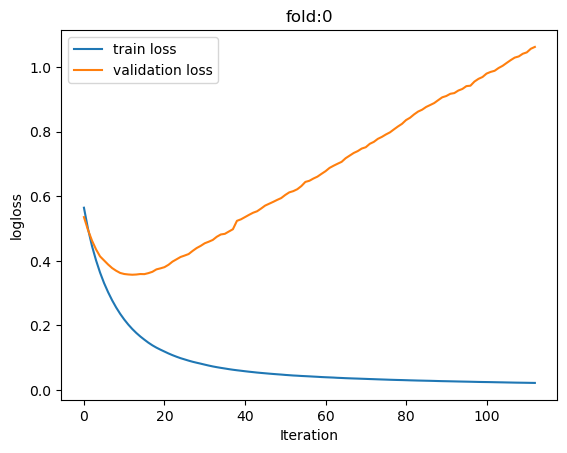

100%|██████████| 30/30 [00:00<00:00, 389.50it/s]


Fold 0:
TN  FP
FN  TP
[[201435   3621]
 [   424    399]]
Accuracy: 0.980352537169891
Recall: 0.4848116646415553
Precision: 0.09925373134328358
F1 score : 0.16477390047491225
---------------------------------------------

[LightGBM] [Info] Number of positive: 5146, number of negative: 605720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3619
[LightGBM] [Info] Number of data points in the train set: 610866, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704904 -> initscore=0.870761
[LightGBM] [Info] Start training from score 0.870761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	Train's binary_logloss: 0.131069	Test's binary_logloss: 0.290494


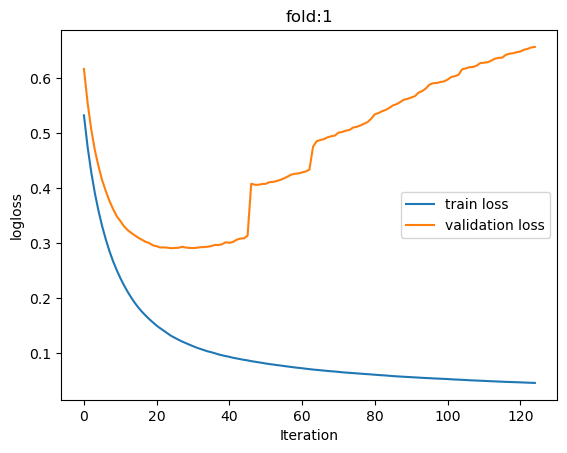

100%|██████████| 30/30 [00:00<00:00, 347.53it/s]


Fold 1:
TN  FP
FN  TP
[[203819   1237]
 [   529    294]]
Accuracy: 0.9914221460178065
Recall: 0.3572296476306197
Precision: 0.19203135205747876
F1 score : 0.24978759558198807
---------------------------------------------

[LightGBM] [Info] Number of positive: 6746, number of negative: 909551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 916297, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.675892 -> initscore=0.734958
[LightGBM] [Info] Start training from score 0.734958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	Train's binary_logloss: 0.105398	Test's binary_logloss: 0.245634


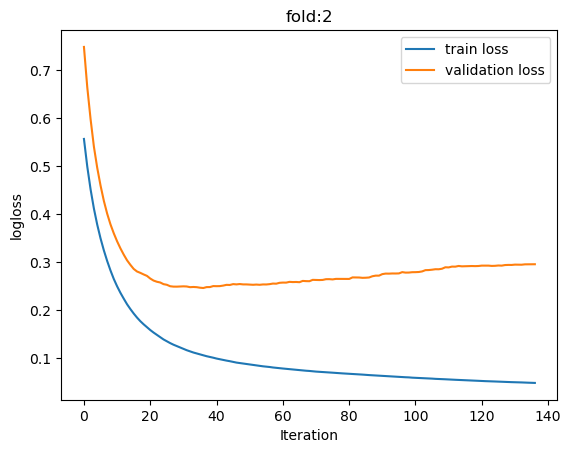

100%|██████████| 30/30 [00:00<00:00, 310.35it/s]


Fold 2:
TN  FP
FN  TP
[[203456   1600]
 [   484    339]]
Accuracy: 0.9898775494343766
Recall: 0.41190765492102066
Precision: 0.17483238782877772
F1 score : 0.24547429398986242
---------------------------------------------

[LightGBM] [Info] Number of positive: 7345, number of negative: 1214383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3758
[LightGBM] [Info] Number of data points in the train set: 1221728, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629713 -> initscore=0.530988
[LightGBM] [Info] Start training from score 0.530988
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	Train's binary_logloss: 0.135132	Test's binary_logloss: 0.288982


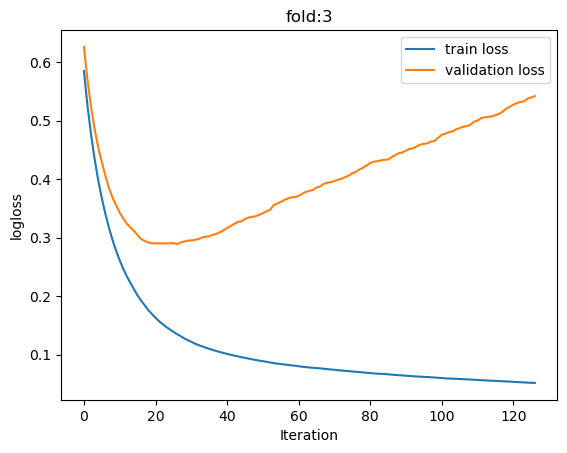

100%|██████████| 30/30 [00:00<00:00, 254.21it/s]


Fold 3:
TN  FP
FN  TP
[[203564   1492]
 [   463    360]]
Accuracy: 0.9905041310672774
Recall: 0.4374240583232078
Precision: 0.19438444924406048
F1 score : 0.2691588785046729
---------------------------------------------

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 8682, number of negative: 1518477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3785
[LightGBM] [Info] Number of data points in the train set: 1527159, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616507 -> initscore=0.474748
[LightGBM] [Info] Start training from scor

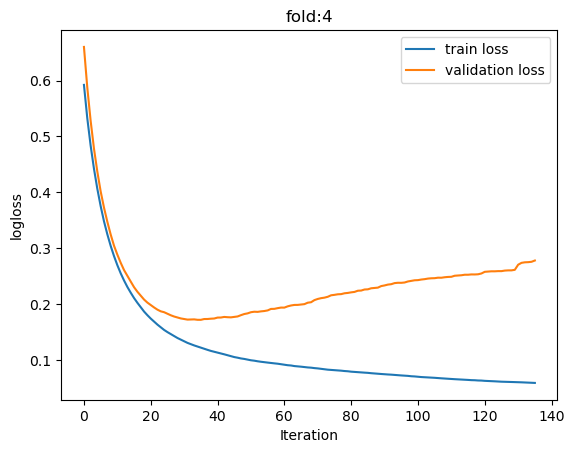

100%|██████████| 30/30 [00:00<00:00, 278.49it/s]


Fold 4:
TN  FP
FN  TP
[[203605   1451]
 [   463    360]]
Accuracy: 0.9907032771676567
Recall: 0.4374240583232078
Precision: 0.19878520154610713
F1 score : 0.2733485193621868
---------------------------------------------



In [128]:
lgb_models_binary = []
best_thresholds = []

params = {
        'boosting_type': 'gbdt',      # GBDTを指定
        'objective': 'binary',    # 回帰を指定
        'metric': 'binary_logloss',             # 回帰の損失（誤差）
        'seed': 123                   # シード値
        }


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train['is_congestion_tomorrow']
    train_x = train.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_binary], axis=1)
    val_y = val['is_congestion_tomorrow']
    val_x = val.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_binary], axis=1)
    
    weight_train = train['weight_binary']
    weight_val = val['weight_binary']
    
    lgb_train = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_val = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(
                params,
                lgb_train,
                categorical_feature=categorical_features,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['Train', 'Test'],
                num_boost_round=100000,
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)] ) 
    
    best_params = model.params
    
    lgb_models_binary.append(model)
    
    loss_train = lgb_results['Train']['binary_logloss']
    loss_test = lgb_results['Test']['binary_logloss']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='validation loss')
    
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_binary.groupby(test_x_binary['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', 'is_congestion_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer = answer_df['is_congestion_tomorrow']
    prediction = answer_df['prediction']
    best_threshold = find_optimal_threshold(answer, prediction)[1]
    best_thresholds.append(best_threshold)
    best_predict = (prediction > best_threshold).astype(int)
    
    predictions.append(best_predict)
    
    accuracy = accuracy_score(answer, best_predict)
    recall = recall_score(answer, best_predict)
    precision = precision_score(answer, best_predict)
    f1 = f1_score(answer, best_predict)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer, best_predict))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 305435, number of used features: 16
[LightGBM] [Info] Start training from score 61.192388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 13.4739	Test's rmse: 22.6056


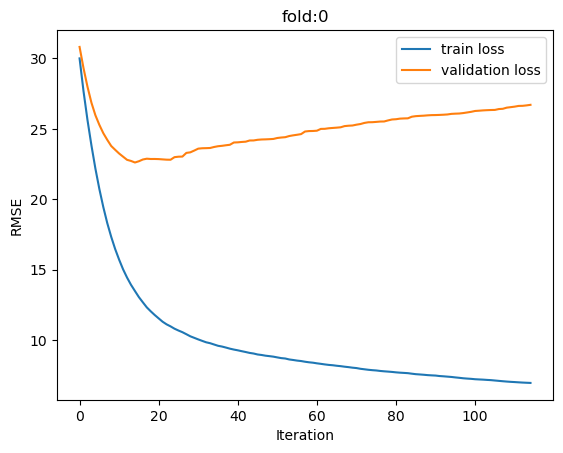

100%|██████████| 30/30 [00:00<00:00, 362.12it/s]


Fold 0:
TN  FP
FN  TP
[[204375    681]
 [   746     77]]
Accuracy: 0.9930687442624065
Recall: 0.09356014580801944
Precision: 0.10158311345646438
F1 score : 0.09740670461733081
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 610866, number of used features: 16
[LightGBM] [Info] Start training from score 56.833594
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	Train's rmse: 11.5379	Test's rmse: 18.3986


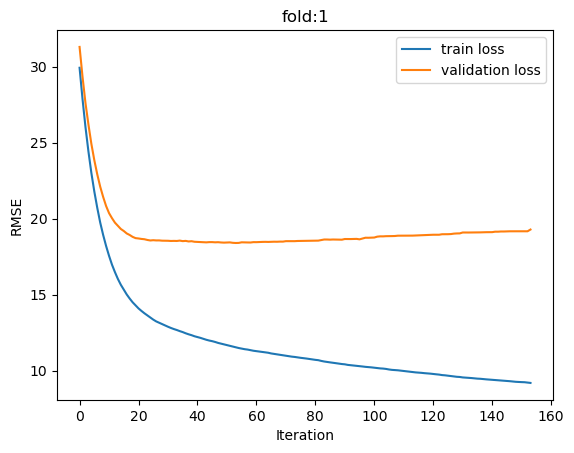

100%|██████████| 30/30 [00:00<00:00, 244.18it/s]


Fold 1:
TN  FP
FN  TP
[[203180   1876]
 [   510    313]]
Accuracy: 0.988410668402314
Recall: 0.38031591737545567
Precision: 0.14298766560073092
F1 score : 0.20783532536520583
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3140
[LightGBM] [Info] Number of data points in the train set: 916297, number of used features: 16
[LightGBM] [Info] Start training from score 58.826442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 13.523	Test's rmse: 19.4254


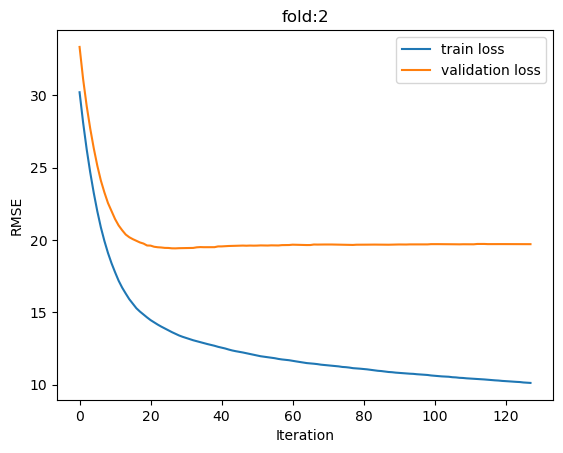

100%|██████████| 30/30 [00:00<00:00, 296.38it/s]


Fold 2:
TN  FP
FN  TP
[[201085   3971]
 [   394    429]]
Accuracy: 0.9787982261425401
Recall: 0.5212636695018226
Precision: 0.0975
F1 score : 0.1642734060884549
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3248
[LightGBM] [Info] Number of data points in the train set: 1221728, number of used features: 16
[LightGBM] [Info] Start training from score 62.008668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	Train's rmse: 13.7657	Test's rmse: 20.1997


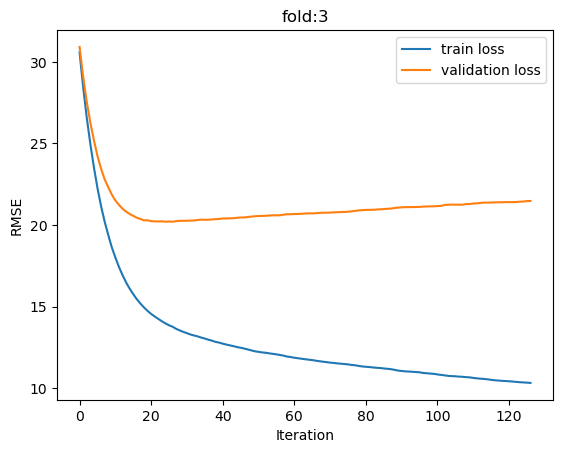

100%|██████████| 30/30 [00:00<00:00, 312.02it/s]


Fold 3:
TN  FP
FN  TP
[[201924   3132]
 [   386    437]]
Accuracy: 0.9829122931430597
Recall: 0.5309842041312273
Precision: 0.12244326141776408
F1 score : 0.19899817850637525
---------------------------------------------

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 1527159, number of used features: 16
[LightGBM] [Info] Start training from score 63.275595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	Train's rmse: 13.2032	Test's rmse: 1

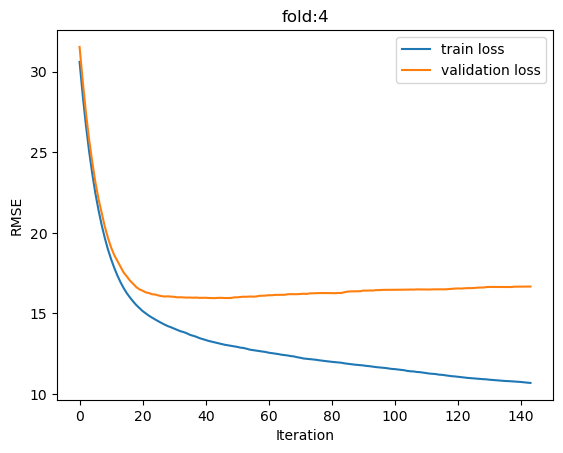

100%|██████████| 30/30 [00:00<00:00, 104.32it/s]


Fold 4:
TN  FP
FN  TP
[[201553   3503]
 [   382    441]]
Accuracy: 0.9811296926835665
Recall: 0.5358444714459295
Precision: 0.11181541582150101
F1 score : 0.18502202643171806
---------------------------------------------



In [129]:

lgb_models_reg = []

params = {
        'boosting_type': 'gbdt',      # GBDTを指定
        'objective': 'regression',    # 回帰を指定
        'metric': 'rmse',             # 回帰の損失（誤差）
        'seed': 123                   # シード値
        }


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train['speed_tomorrow']
    train_x = train.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_reg], axis=1)
    val_y = val['speed_tomorrow']
    val_x = val.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_reg], axis=1)
    
    weight_train = train['weight_reg']
    weight_val = val['weight_reg']
    
    lgb_train = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_val = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(
                params,
                lgb_train,
                categorical_feature=categorical_features,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['Train', 'Test'],
                num_boost_round=100000,
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)] ) 
    
    best_params = model.params
    
    lgb_models_reg.append(model)
    
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='validation loss')
    
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_reg.groupby(test_x_reg['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', 'speed_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer_binary = (answer_df['speed_tomorrow'] <= 40).astype(int)
    prediction_binary = (answer_df['prediction'] <= 40).astype(int)
    
    predictions.append(prediction_binary)
    
    accuracy = accuracy_score(answer_binary, prediction_binary)
    recall = recall_score(answer_binary, prediction_binary)
    precision = precision_score(answer_binary, prediction_binary)
    f1 = f1_score(answer_binary, prediction_binary)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer_binary, prediction_binary))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

In [130]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [131]:
sub_df = df_test[['datetime', 'start_code', 'end_code', 'KP']]
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df['prediction'] = majority_predictions
sub_df['datetime'] += pd.to_timedelta(1, 'd')
answer_df = pd.merge(sub_df, df_test[['datetime', 'start_code', 'end_code', 'KP', 'holiday', 'is_congestion']], on=['datetime', 'start_code', 'end_code', 'KP'], how='inner')
answer_holiday_df = answer_df.loc[(answer_df['holiday'] == 1)]
answer = answer_df['is_congestion']
answer_holiday = answer_holiday_df['is_congestion']
prediction = answer_df['prediction']
prediction_holiday =answer_holiday_df['prediction']

accuracy = accuracy_score(answer, prediction)
recall = recall_score(answer, prediction)
precision = precision_score(answer, prediction)
f1 = f1_score(answer, prediction)

accuracy_holiday = accuracy_score(answer_holiday, prediction_holiday)
recall_holiday = recall_score(answer_holiday, prediction_holiday)
precision_holiday = precision_score(answer_holiday, prediction_holiday)
f1_holiday = f1_score(answer_holiday, prediction_holiday)

print('Voting:\n')
print('All days')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, prediction))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')
print('\n')
print('Only holiday')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer_holiday, prediction_holiday))
print(f'Accuracy: {accuracy_holiday}')
print(f'Recall: {recall_holiday}')
print(f'Precision: {precision_holiday}')
print(f'F1 score : {f1_holiday}')

Voting:

All days
TN  FP
FN  TP
[[196670   1528]
 [   414    367]]
Accuracy: 0.9902401760989853
Recall: 0.469910371318822
Precision: 0.19366754617414247
F1 score : 0.27428998505231694


Only holiday
TN  FP
FN  TP
[[61002   320]
 [  208   220]]
Accuracy: 0.9914493927125506
Recall: 0.514018691588785
Precision: 0.4074074074074074
F1 score : 0.45454545454545453


In [132]:
best_thresholds

[0.8282828282828284,
 0.9494949494949496,
 0.9494949494949496,
 0.9393939393939394,
 0.9494949494949496]

In [133]:
model_names = {
    0: "model_binary_fold_0",
    1: "model_binary_fold_1",
    2: "model_binary_fold_2",
    3: "model_binary_fold_3",
    4: "model_binary_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models_binary):
    model_name = model_names.get(fold, f'model_binary_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)
        

model_names = {
    0: "model_reg_fold_0",
    1: "model_reg_fold_1",
    2: "model_reg_fold_2",
    3: "model_reg_fold_3",
    4: "model_reg_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models_reg):
    model_name = model_names.get(fold, f'model_reg_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)